<a href="https://colab.research.google.com/github/DiogoMondin/open_market_tariff_model/blob/main/open_market_tariff_r_model_BR_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install pyspark>=3.5.0
!pip install pyspark openpyxl
!wget https://repo1.maven.org/maven2/com/crealytics/spark-excel_2.12/3.5.0_0.18.7/spark-excel_2.12-3.5.0_0.18.7.jar -P /content/

--2025-06-17 02:05:38--  https://repo1.maven.org/maven2/com/crealytics/spark-excel_2.12/3.5.0_0.18.7/spark-excel_2.12-3.5.0_0.18.7.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-06-17 02:05:38 ERROR 404: Not Found.



In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from datetime import datetime, timedelta

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
spark = SparkSession.builder \
    .appName("TCC") \
    .config("spark.jars", "/content/spark-excel_2.12-3.5.0_0.18.7.jar") \
    .getOrCreate()

#  Input tables

In [4]:
# Brasil

ANEEL_COMPONENTES_TARIFARIAS_2025 =         "/content/drive/MyDrive/Colab Files/tcc/brasil/aneel/componentes-tarifarias-2025.csv"
ANEEL_COMPONENTES_TARIFARIAS_2024 =         "/content/drive/MyDrive/Colab Files/tcc/brasil/aneel/componentes-tarifarias-2024.csv"
ANEEL_COMPONENTES_TARIFARIAS_2023 =         "/content/drive/MyDrive/Colab Files/tcc/brasil/aneel/componentes-tarifarias-2023.csv"
ANEEL_COMPONENTES_TARIFARIAS_2022 =         "/content/drive/MyDrive/Colab Files/tcc/brasil/aneel/componentes-tarifarias-2022.csv"
ANEEL_COMPONENTES_TARIFARIAS_2021 =         "/content/drive/MyDrive/Colab Files/tcc/brasil/aneel/componentes-tarifarias-2021.csv"
ANEEL_COMPONENTES_TARIFARIAS_2020 =         "/content/drive/MyDrive/Colab Files/tcc/brasil/aneel/componentes-tarifarias-2020.csv"
ANEEL_COMPONENTES_TARIFARIAS_2019 =         "/content/drive/MyDrive/Colab Files/tcc/brasil/aneel/componentes-tarifarias-2019.csv"
ANEEL_COMPONENTES_TARIFARIAS_2018 =         "/content/drive/MyDrive/Colab Files/tcc/brasil/aneel/componentes-tarifarias-2018.csv"
ANEEL_COMPONENTES_TARIFARIAS_2017 =         "/content/drive/MyDrive/Colab Files/tcc/brasil/aneel/componentes-tarifarias-2017.csv"
ANEEL_COMPONENTES_TARIFARIAS_2016 =         "/content/drive/MyDrive/Colab Files/tcc/brasil/aneel/componentes-tarifarias-2016.csv"

# Portugal

DGEG_PED_NORMALIZED_2024 =                  "/content/drive/MyDrive/Colab Files/tcc/portugal/dgeg/dgeg-ped-1985-2024-s2_pt_normalized.csv"

# BR dataframes

In [5]:
aneel_componentes_tarifarias_2024_df = (
    spark.read.option("header", True)
    .option("delimiter", ";")
    .option("encoding", "ISO-8859-1")
    .csv(ANEEL_COMPONENTES_TARIFARIAS_2024)
    .withColumn("ano", F.when(F.col("DatInicioVigencia") > "2024-06-30", "2024.2").otherwise("2024.1"))
)

aneel_componentes_tarifarias_2023_df = (
    spark.read.option("header", True)
    .option("delimiter", ";")
    .option("encoding", "ISO-8859-1")
    .csv(ANEEL_COMPONENTES_TARIFARIAS_2023)
    .withColumn("ano", F.when(F.col("DatInicioVigencia") > "2023-06-30", "2023.2").otherwise("2023.1"))
)

aneel_componentes_tarifarias_2022_df = (
    spark.read.option("header", True)
    .option("delimiter", ";")
    .option("encoding", "ISO-8859-1")
    .csv(ANEEL_COMPONENTES_TARIFARIAS_2022)
    .withColumn("ano", F.when(F.col("DatInicioVigencia") > "2022-06-30", "2022.2").otherwise("2022.1"))
)

aneel_componentes_tarifarias_2021_df = (
    spark.read.option("header", True)
    .option("delimiter", ";")
    .option("encoding", "ISO-8859-1")
    .csv(ANEEL_COMPONENTES_TARIFARIAS_2021)
    .withColumn("ano", F.when(F.col("DatInicioVigencia") > "2021-06-30", "2021.2").otherwise("2021.1"))
)

aneel_componentes_tarifarias_2020_df = (
    spark.read.option("header", True)
    .option("delimiter", ";")
    .option("encoding", "ISO-8859-1")
    .csv(ANEEL_COMPONENTES_TARIFARIAS_2020)
    .withColumn("ano", F.when(F.col("DatInicioVigencia") > "2020-06-30", "2020.2").otherwise("2020.1"))
)

aneel_componentes_tarifarias_2019_df = (
    spark.read.option("header", True)
    .option("delimiter", ";")
    .option("encoding", "ISO-8859-1")
    .csv(ANEEL_COMPONENTES_TARIFARIAS_2019)
    .withColumn("ano", F.when(F.col("DatInicioVigencia") > "2019-06-30", "2019.2").otherwise("2019.1"))
)

aneel_componentes_tarifarias_2018_df = (
    spark.read.option("header", True)
    .option("delimiter", ";")
    .option("encoding", "ISO-8859-1")
    .csv(ANEEL_COMPONENTES_TARIFARIAS_2018)
    .withColumn("ano", F.when(F.col("DatInicioVigencia") > "2018-06-30", "2018.2").otherwise("2018.1"))
)

aneel_componentes_tarifarias_2017_df = (
    spark.read.option("header", True)
    .option("delimiter", ";")
    .option("encoding", "ISO-8859-1")
    .csv(ANEEL_COMPONENTES_TARIFARIAS_2017)
    .withColumn("ano", F.when(F.col("DatInicioVigencia") > "2017-06-30", "2017.2").otherwise("2017.1"))
)

aneel_componentes_tarifarias_2016_df = (
    spark.read.option("header", True)
    .option("delimiter", ";")
    .option("encoding", "ISO-8859-1")
    .csv(ANEEL_COMPONENTES_TARIFARIAS_2016)
    .withColumn("ano", F.when(F.col("DatInicioVigencia") > "2016-06-30", "2016.2").otherwise("2016.1"))
)

In [6]:
icms = 0.18
pis_cofins = 0.0473
total_impostos = icms + pis_cofins
fator_divisor = 1 + total_impostos

componentes_validos = ['TUSD_FioB', 'TE', 'TE_PeD', 'TUSD_CUSD', 'TUSD_RGR']

aneel_componentes_tarifarias_df = (
  aneel_componentes_tarifarias_2024_df
  .unionByName(aneel_componentes_tarifarias_2023_df)
  .unionByName(aneel_componentes_tarifarias_2022_df)
  .unionByName(aneel_componentes_tarifarias_2021_df)
  .unionByName(aneel_componentes_tarifarias_2020_df)
  .unionByName(aneel_componentes_tarifarias_2019_df)
  .unionByName(aneel_componentes_tarifarias_2018_df)
  .unionByName(aneel_componentes_tarifarias_2017_df)
  .unionByName(aneel_componentes_tarifarias_2016_df)
  .filter(F.col("DscComponenteTarifario").isin(componentes_validos))
  .filter(F.col("DscSubGrupoTarifario") == "B1")
  .withColumn("VlrComponenteTarifario", F.regexp_replace(F.col("VlrComponenteTarifario"), ",", ".").cast(T.DoubleType()))
  .withColumn("VlrComponenteTarifario_KWh",
      F.when(F.col("DscUnidade") == "R$/MWh", F.col("VlrComponenteTarifario") / 1000)
      .otherwise(F.col("VlrComponenteTarifario"))
  )
  .withColumn("VlrComponenteTarifario_KWh_sem_impostos_fiscas",
      (F.col("VlrComponenteTarifario_KWh") / fator_divisor)
  )
  .withColumn(
    "consumo_min",
    F.when(F.col("DscSubGrupoTarifario").isin("B4", "A2"), ">= 0")
    .when(F.col("DscSubGrupoTarifario").isin("B2", "B", "B1", "B3"), ">= 1000")
    .when(F.col("DscSubGrupoTarifario").isin("A4", "A3", "A3a"), ">= 2500")
    .when(F.col("DscSubGrupoTarifario").isin("A1", "AS"), ">= 5000")
  )
  .withColumn(
    "consumo_max",
    F.when(F.col("DscSubGrupoTarifario").isin("B4", "A2"), "< 1000")
    .when(F.col("DscSubGrupoTarifario").isin("B2", "B", "B1", "B3"), "< 2500")
    .when(F.col("DscSubGrupoTarifario").isin("A4", "A3", "A3a"), "< 5000")
    .when(F.col("DscSubGrupoTarifario").isin("A1", "AS"), "< 15000")
    .otherwise(None)
  )
  .groupBy("ano", "DscSubGrupoTarifario", "consumo_min", "consumo_max")
  .agg(
      F.avg("VlrComponenteTarifario_KWh").alias("tarifa_com_impostos"),
      F.avg("VlrComponenteTarifario_KWh_sem_impostos_fiscas").alias("tarifa_sem_impostos")
  )
  .orderBy("ano", "consumo_min", "consumo_max")
)

aneel_componentes_tarifarias_df.show()

+------+--------------------+-----------+-----------+--------------------+--------------------+
|   ano|DscSubGrupoTarifario|consumo_min|consumo_max| tarifa_com_impostos| tarifa_sem_impostos|
+------+--------------------+-----------+-----------+--------------------+--------------------+
|2016.1|                  B1|    >= 1000|     < 2500| 0.05661933406193387|  0.0461332470153457|
|2016.2|                  B1|    >= 1000|     < 2500|0.061306970535493305| 0.04995271778333994|
|2017.1|                  B1|    >= 1000|     < 2500| 0.05925535511567488| 0.04828106829273595|
|2017.2|                  B1|    >= 1000|     < 2500| 0.06366099624598369| 0.05187077018331589|
|2018.1|                  B1|    >= 1000|     < 2500| 0.07201275621963277| 0.05867575671769961|
|2018.2|                  B1|    >= 1000|     < 2500| 0.07315064632495563| 0.05960290582983404|
|2019.1|                  B1|    >= 1000|     < 2500| 0.07863991352360906|  0.0640755426738441|
|2019.2|                  B1|    >= 1000

# PT dataframes

In [7]:
deg_prices_df = (
    spark.read.option("header", True)
    .option("delimiter", ",")
    .option("encoding", "ISO-8859-1")
    .csv(DGEG_PED_NORMALIZED_2024)
)

deg_prices_df =(
    deg_prices_df
    .filter(F.col("bandas_de_consumo") == "Banda - DC")
    .withColumn("ano", F.col("ano").cast("string"))
    .withColumn("bandas_de_consumo", F.col("bandas_de_consumo").cast("string"))
    .withColumn("consumo_anual_euro_kwh_minimo", F.col("consumo_anual_euro_kwh_minimo").cast("string"))
    .withColumn("consumo_anual_euro_kwh_maximo", F.col("consumo_anual_euro_kwh_maximo").cast("string"))
    .withColumn("precos_euro_kwh_excluindo_impostos_taxa_direitos_e_encargos", F.col("precos_euro_kwh_excluindo_impostos_taxa_direitos_e_encargos").cast("float"))
    .withColumn("precos_euro_kwh_excluindo_IVA_e_outros_impostos_recuperaveis", F.col("precos_euro_kwh_excluindo_IVA_e_outros_impostos_recuperaveis").cast("float"))
    .withColumn("precos_euro_kwh_incluindo_impostos_e_taxas", F.col("precos_euro_kwh_incluindo_impostos_e_taxas").cast("float"))
    .withColumn(
      "consumo_anual_euro_kwh_minimo",
      F.trim(F.regexp_replace(F.regexp_replace(F.col("consumo_anual_euro_kwh_minimo"), r"\?", ">="), "< 1 000", ">= 0"))
    )
    .withColumn("consumo_anual_euro_kwh_maximo", F.trim(F.regexp_replace(F.col("consumo_anual_euro_kwh_maximo"), r"\?", ">=")))
)

deg_prices_df.show()

+------+-----------------+-----------------------------+-----------------------------+-----------------------------------------------------------+------------------------------------------------------------+------------------------------------------+
|   ano|bandas_de_consumo|consumo_anual_euro_kwh_minimo|consumo_anual_euro_kwh_maximo|precos_euro_kwh_excluindo_impostos_taxa_direitos_e_encargos|precos_euro_kwh_excluindo_IVA_e_outros_impostos_recuperaveis|precos_euro_kwh_incluindo_impostos_e_taxas|
+------+-----------------+-----------------------------+-----------------------------+-----------------------------------------------------------+------------------------------------------------------------+------------------------------------------+
|2024.2|       Banda - DC|                     >= 2 500|                      < 5 000|                                                 0.16926965|                                                  0.22246562|                                 0.26260

In [8]:
# BR
brasil_pdf = (
    aneel_componentes_tarifarias_df
    .select("ano", "tarifa_sem_impostos", "tarifa_com_impostos")
    .groupBy("ano")
    .agg(
        F.avg("tarifa_sem_impostos").alias("brasil_sem_impostos"),
        F.avg("tarifa_com_impostos").alias("brasil_com_impostos")
    )
    .orderBy("ano")
    .toPandas()
)

# PT
portugal_pdf = (
    deg_prices_df
    .groupBy("ano")
    .agg(
        F.avg("precos_euro_kwh_excluindo_impostos_taxa_direitos_e_encargos").alias("portugal_sem_impostos"),
        F.avg("precos_euro_kwh_incluindo_impostos_e_taxas").alias("portugal_com_impostos")
    )
    .orderBy("ano")
    .toPandas()
)

# Merge
df_merge = pd.merge(brasil_pdf, portugal_pdf, on="ano", how="inner")
df_merge["ano"] = df_merge["ano"].astype(float)
df_merge["ano_int"] = df_merge["ano"].astype(int)

# Post PT open market (2018)
pt_pos_2018 = df_merge[df_merge["ano"] >= 2018.0].copy()

# Baseline BR (last snapshot year 2024)
valor_base_brasil = df_merge[df_merge["ano"] == 2024.2]["brasil_com_impostos"].values[0]

# Projected years
anos_projetados = np.arange(2025, 2025 + len(pt_pos_2018) - 1, 1)

# Percentage variation

In [9]:
# YoY percentage variation in PT
pt_pos_2018["pt_pct_change"] = pt_pos_2018["portugal_com_impostos"].pct_change()
pt_pos_2018 = pt_pos_2018.dropna(subset=["pt_pct_change"])

# Applied percentage sequence in BR
projecoes_brasil_pct = [valor_base_brasil]
for pct in pt_pos_2018["pt_pct_change"].values:
    novo_valor = projecoes_brasil_pct[-1] * (1 + pct)
    projecoes_brasil_pct.append(novo_valor)
projecoes_brasil_pct = projecoes_brasil_pct[1:]

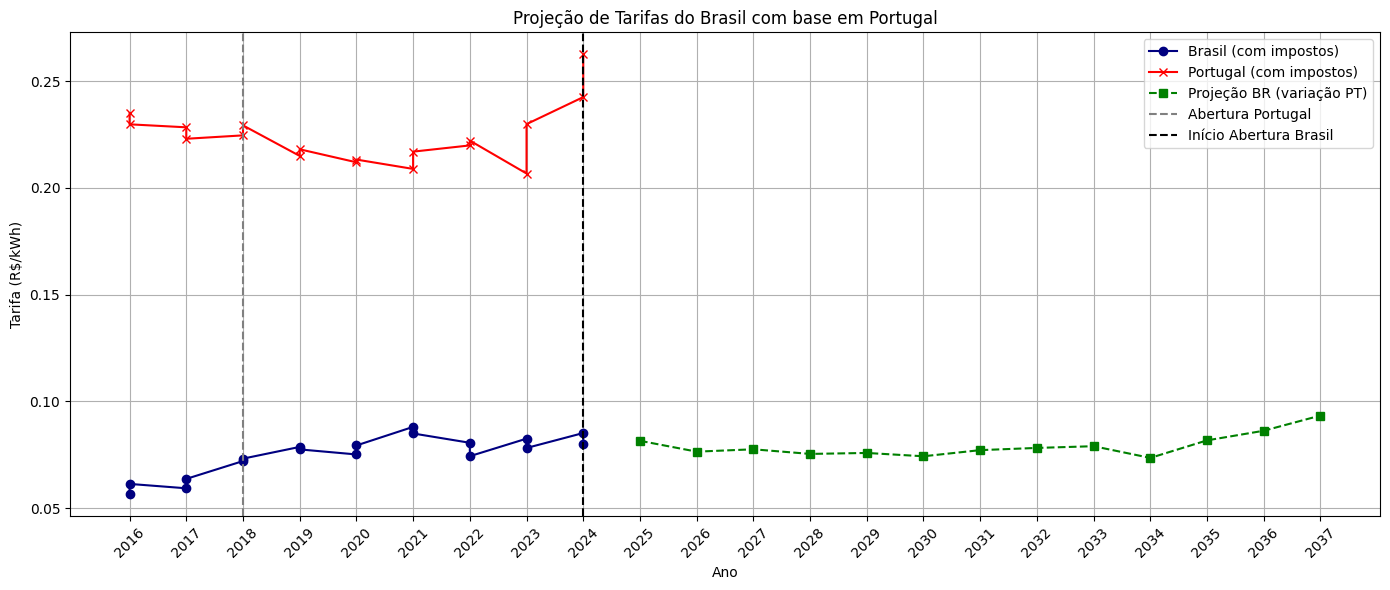

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(df_merge["ano_int"], df_merge["brasil_com_impostos"], label="Brasil (com impostos)", marker='o', color='navy')
plt.plot(df_merge["ano_int"], df_merge["portugal_com_impostos"], label="Portugal (com impostos)", marker='x', color='red')

plt.plot(anos_projetados, projecoes_brasil_pct, '--', label="Projeção BR (variação PT)", marker='s', color='green')

plt.axvline(x=2018, color='gray', linestyle='--', label="Abertura Portugal")
plt.axvline(x=2024, color='black', linestyle='--', label="Início Abertura Brasil")

plt.title("Projeção de Tarifas do Brasil com base em Portugal")
plt.xlabel("Ano")
plt.ylabel("Tarifa (R$/kWh)")
plt.xticks(np.unique(np.append(df_merge["ano_int"], anos_projetados)), rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Linear Regression

In [11]:
# Baseline PT post market opening (2018)
X_pt = pt_pos_2018[["ano"]].values
y_pt = pt_pos_2018["portugal_com_impostos"].values

modelo = LinearRegression()
modelo.fit(X_pt, y_pt)

slope = modelo.coef_[0]

# Baseline BR post simulated market opening (2024)
projecoes_brasil_reg = [valor_base_brasil + slope * (ano - 2024) for ano in anos_projetados]

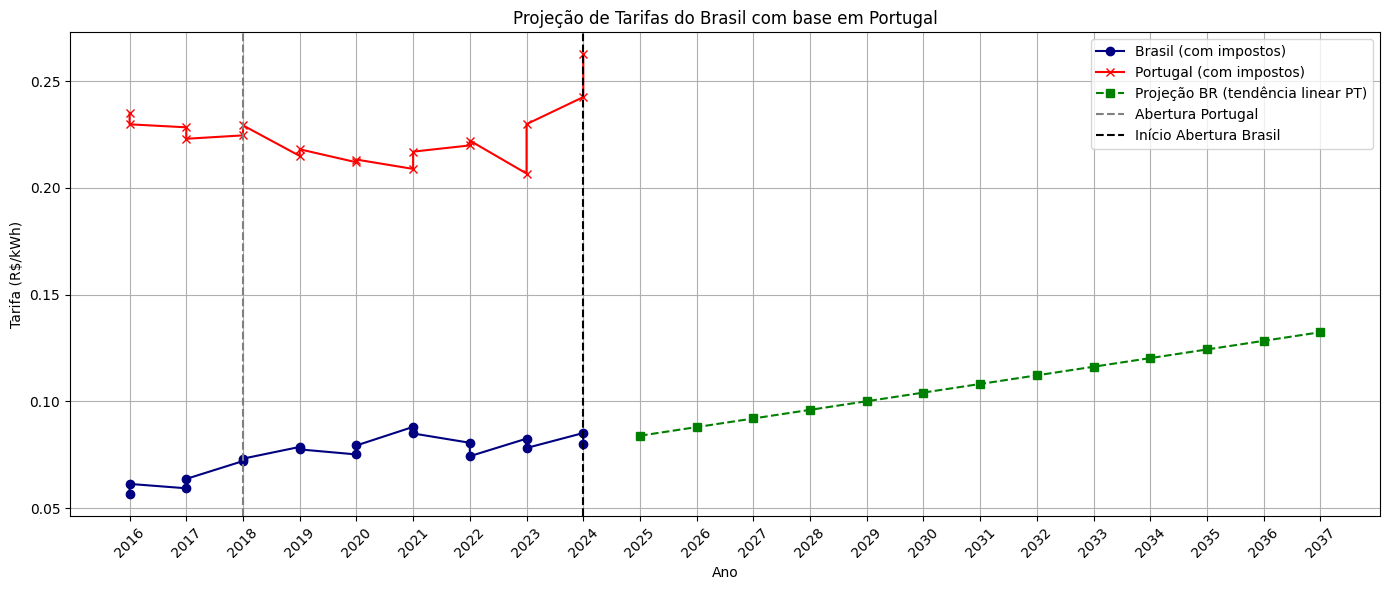

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(df_merge["ano_int"], df_merge["brasil_com_impostos"], label="Brasil (com impostos)", marker='o', color='navy')
plt.plot(df_merge["ano_int"], df_merge["portugal_com_impostos"], label="Portugal (com impostos)", marker='x', color='red')

plt.plot(anos_projetados, projecoes_brasil_reg, '--', label="Projeção BR (tendência linear PT)", marker='s', color='green')

plt.axvline(x=2018, color='gray', linestyle='--', label="Abertura Portugal")
plt.axvline(x=2024, color='black', linestyle='--', label="Início Abertura Brasil")

plt.title("Projeção de Tarifas do Brasil com base em Portugal")
plt.xlabel("Ano")
plt.ylabel("Tarifa (R$/kWh)")
plt.xticks(np.unique(np.append(df_merge["ano_int"], anos_projetados)), rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()